<div class="alert alert-block alert-info" style="margin-top: 20px">

<a id = "Table_of_content"></a>
<h1>Table of Contents</h1>

### 1. [Import all require library](#T1)
### 2. [Image Preprocessing](#T2)
#### &emsp; ---➤ [Rename the image files](#T21)
#### &emsp; ---➤ [Resize the image](#T22)
#### &emsp; ---➤ [Convert RGB to HSI](#T23)
#### &emsp; ---➤ [Convert dataset to tensor](#T24)
#### &emsp; ---➤ [Gaussian low pass filter](#T25)
#### &emsp; ---➤ [Splitting the dataset into training, testing and validation](#T26)
#### &emsp; ---➤ [Data Augmentation in training dataset](#T27)
#### &emsp; ---➤ [Move the dataset to DataLoader](#T28)
### 3. [Feature Extraction using CNN Autoencoder](#T3)
#### &emsp; ---➤ [Training](#T31)
#### &emsp; ---➤ [Use model to reconstruct the image](#T32)
    
### 4. [Day/Dusk/Night Classification Model](#T4)
#### &emsp; ---➤ [Training](#T41)
#### &emsp; ---➤ [Evaluating on test dataset](#T42)
### 5. [Use top 10 best model to classify Day/Dusk/Night](#T5)
</div>

<a id = "T1"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Import all require library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import cv2

<a id = "T2"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Image Preprocessing
* Our original image come from difference size (as it is capture by difference phone), these involve (4096, 3072), (4030, 3024), (4000, 3000), ...
<br><br>
* These sizes have 2 problems. 
  - First, all the size it not equal shape. 
  - Second, the size is too large for feeding into the model as for 1 (4000,3000) image, it contains 4000 * 3000 * 3 = 36,000,000 (which is about 36 million data!)
<br><br>
* Therefore, we will do some image preprocessing to reduce the size of the image and remove the noise from the data:
  - First, we will __resize the image to 'new_size' which is (80, 80)__ using torchvision.transforms.Resize() function. The reason that we does not resize to smaller size is because it will become more blur when we resize too more and it will loss too many information. The reason that we does not resize to larger size is because the data will be increasing when dimension increase
  - Then, the __image is converted from RGB color model to HSV color model__ and __is normalized to 0-1__. Note that we cannot convert to greyscale value as our classification is mainly due with the difference light intensity. Convert to greyscale image will loss this infomation.
  - Next, we will __applied a 7x7 gaussian low-pass filter__ with padding = "same" to reduce the noise of the data. We select 7x7 instead of 3x3 filter as our image usually is full of noise(unwanted infomation to predict Day, Dusk, Night)
  - Finally, we will do __data augmentation to double the training data.__
<br><br>
* Now, for 1 image, we will have (3, 80, 80) data, this is still quite a lot (19200 data per image). Therefore, we will apply some technique to do feature extraction in "Feature Extraction using CNN Autoencoder" section to reduce the dimension while extract most important information

* Let put the arrange the ipynb files and image files follow the following directory and change the folder_path below to your corresponding directory
```
   |---DayDuskAndNightClassification.ipynb
   |---Database
       |---Day
       |---Dusk
       |---Night
```

In [3]:
# Folder path that contains all the folder of ['Day', 'Dusk', 'Night']
folder_path = os.getcwd() + "\Database"
labels = ['Day', 'Dusk', 'Night']                             # All the label of the image
new_size   = (80, 80)                                         # New size of the image 
torch.manual_seed(0)                                          # Set the random seed for cpu
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)                             # Set the random seed for gpu if cuda is available
    
convert_RGB2HSV  = 0
applied_Gaussian = 1

<a id = "T21"></a>
### ➟ Rename the image files

In [4]:
# A function for files renaming
def renameImage(folder, label):  
    
    # First rename all the image file to temp name
    imgList = os.listdir(folder)   # List of image in the folder ['Day', 'Dusk', 'Night']
    for i, filename in enumerate(imgList):
        new_name = f"{label}_tempppp_{i}.jpg"
        src = f"{folder}/{filename}"
        dst = f"{folder}/{new_name}"
        os.rename(src, dst)
    
    # Then rename all image file from temp name to target name
    imgList = os.listdir(folder)   # List of image in the folder ['Day', 'Dusk', 'Night']            
    for i, filename in enumerate(imgList):
        new_name = f"{label}_{i}.jpg"
        src = f"{folder}/{filename}"
        dst = f"{folder}/{new_name}"
        os.rename(src, dst)
    
    print(f"For label {label}, we have {len(imgList)} images")


for label in labels:
    folder = f"{folder_path}/{label}"
    renameImage(folder, label)

For label Day, we have 124 images
For label Dusk, we have 81 images
For label Night, we have 149 images


<a id = "T22"></a>
### ➟ Resize the image 

In [5]:
def re(img_path, new_size):
    img = Image.open(img_path)            # read the input image
    transform = T.Resize(size = new_size) # define transform to resize the image with given size
    img = transform(img)                  # apply the transform on the input image
    return img 

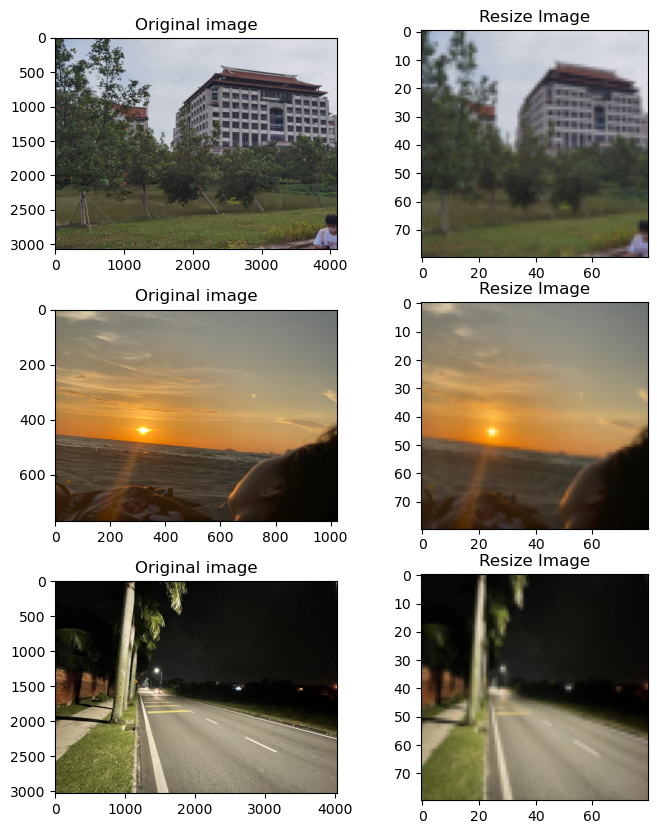

In [6]:
# View sample of resized image
img_review = ["Day_9.jpg" ,"Dusk_1.jpg", "Night_27.jpg", ] 

fig, ax = plt.subplots(len(img_review), 2,figsize=(8,10))

for i, img_name in enumerate(img_review):
    img_path = f"{folder_path}\{img_name[:img_name.index('_')]}\{img_name}"
    
    img = Image.open(img_path)
    ax[i,0].set_title("Original image")
    ax[i,0].imshow(img)
    
    resize_img = re(img_path, new_size)
    ax[i,1].set_title("Resize Image")
    ax[i,1].imshow(resize_img)
    plt.show

In [7]:
files = []          # Get all the path of the image
y     = []          # Get all the label of the image
for i,label in enumerate(labels):
    imgList = os.listdir(f"{folder_path}\{label}")
    for img in imgList:
        files += [os.path.join(folder_path,label,img)]
    y += [i] * len(imgList)
y = np.array(y, dtype = np.int8)

In [8]:
# Resize all the image (This process may take some times)

print("All of images will be resize to",new_size)
img_arr = np.array(re(files[0], new_size))[None,:]  # Shape = (1,new_size,3)

for i in range(1,len(files)):
    img_temp = np.array(re(files[i], new_size))[None,:]
    img_arr = np.concatenate((img_arr, np.array(img_temp)), axis = 0)

Image.MAX_IMAGE_PIXELS = None  # Remove the DecompressionBombWarning
print("Dataset         size =", img_arr.shape)
print("Label           size =", y.shape)

All of images will be resize to (80, 80)


C:\Users\xinju\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Dataset         size = (354, 80, 80, 3)
Label           size = (354,)


<a id = "T23"></a>
### ➟ Convert  RBG to HSI

In [9]:
# # First, since cv2 use the BGR instead of RGB, we need to convert RGB to BGR
if convert_RGB2HSV:
    img_arr[:,:,:,0], img_arr[:,:,:,2] = img_arr[:,:,:,2], img_arr[:,:,:,0]

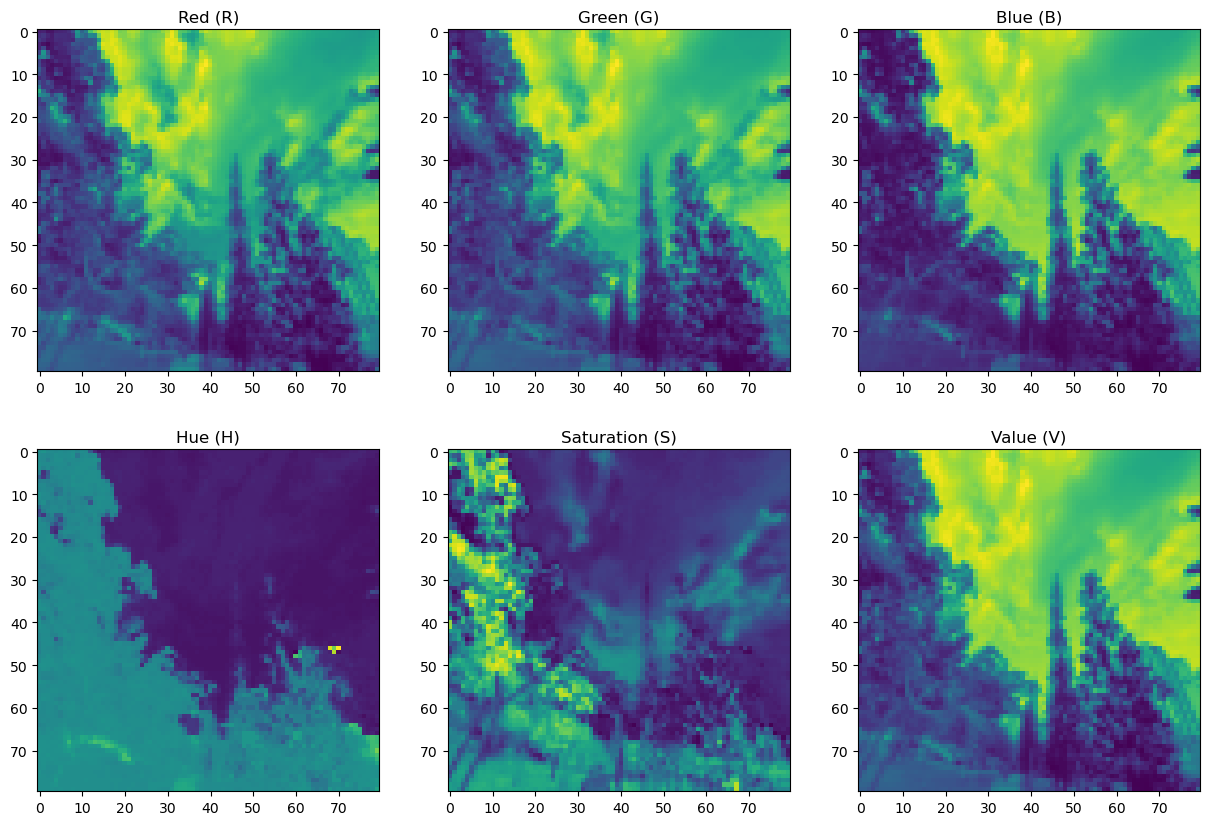

In [10]:
# Show the difference between RGB, HSI
fig, ax = plt.subplots(2, 3,figsize=(15,10))

img_ind = 50
list_title = ["Blue (B)","Green (G)", "Red (R)"] if convert_RGB2HSV else ["Red (R)","Green (G)", "Blue (B)"]
list_title1 = ["Hue (H)", "Saturation (S)", "Value (V)"]
for i in range(3):     
    ax[0,i].set_title(list_title[i])
    ax[0,i].imshow(img_arr[img_ind,:,:,i])

HSV_image = cv2.cvtColor(img_arr[img_ind], cv2.COLOR_BGR2HSV)

for i in range(3):
    ax[1,i].set_title(list_title1[i])
    ax[1,i].imshow(HSV_image[:,:,i])

Text(0.5, 1.0, 'Original Image')

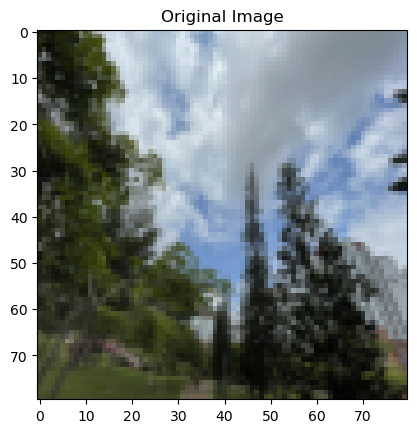

In [11]:
plt.imshow(img_arr[img_ind])
plt.title("Original Image")

In [12]:
if convert_RGB2HSV:
    # Convert all RGB image to HSV image
    for i in range(img_arr.shape[0]):
        img_arr[i] = cv2.cvtColor(img_arr[i], cv2.COLOR_BGR2HSV )

    # Convert to float32 and normalize the data to 0 to 1
    img_arr = np.array(img_arr, dtype =np.float32) 

In [13]:
if convert_RGB2HSV:
   list_title = list_title1 
print(f"{'color':<15} {'max':<5} {'min':<5}")
for i in range(3):
    print(f"{list_title[i]:<15} {np.max(img_arr[:,:,:,i]):<5} {np.min(img_arr[:,:,:,i]):<5}")

color           max   min  
Red (R)         255   0    
Green (G)       255   0    
Blue (B)        255   0    


<a id = "T24"></a>
### ➟ Convert dataset to tensor

In [14]:
# Convert the dataset and label into tensor
# [batch_size, height, weight, channel] --> [batch_size, channel, height, weight]
img_tensors    = (torch.from_numpy(img_arr)).permute(0,3,1,2) / 255
y              = F.one_hot(torch.tensor(y, dtype =torch.int64), num_classes=3) if y.ndim == 1 else y
y              = y.type(torch.float32)   # Convert to float32 so later can feed in Neural network

print("Dataset size =", img_tensors.shape)
print("Label   size =", y.shape)

Dataset size = torch.Size([354, 3, 80, 80])
Label   size = torch.Size([354, 3])


In [15]:
torch.min(img_tensors)

tensor(0.)

<a id = "T25"></a>
### ➟ Gaussian low pass filter
* The formula of the gaussian low pass filter is as below:
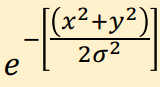
* Lastly, we divide the filter by sum of filter so that the range of our pixel value will be remain
* The reason of doing gaussian low pass filter is to remove high frequency components like edge and remove some noise in the image. The larger the sigma2 OR the larger the size of filter, the blurrer the image

In [16]:
def gauss_eqn(x, y, sigma2):
    return np.exp(-(x**2 + y**2)/(2 * sigma2))
    

def gaussian_filter(kernel_size, sigma2):
        gaussian_filter = np.zeros(kernel_size, np.float32)
        m = kernel_size[0]//2  
        n = kernel_size[1]//2  
        
        for x in range(-m, m+1):
            for y in range(-n, n+1):
                gaussian_filter[x+m, y+n] = gauss_eqn(x, y, sigma2)
            
        return gaussian_filter / gaussian_filter.sum().sum()

In [17]:
# Here is the sample of 3x3 gaussian filter with sigma2 = 2
gaussian_filter((3,3),2)

array([[0.0927229 , 0.11905856, 0.0927229 ],
       [0.11905856, 0.15287422, 0.11905856],
       [0.0927229 , 0.11905856, 0.0927229 ]], dtype=float32)

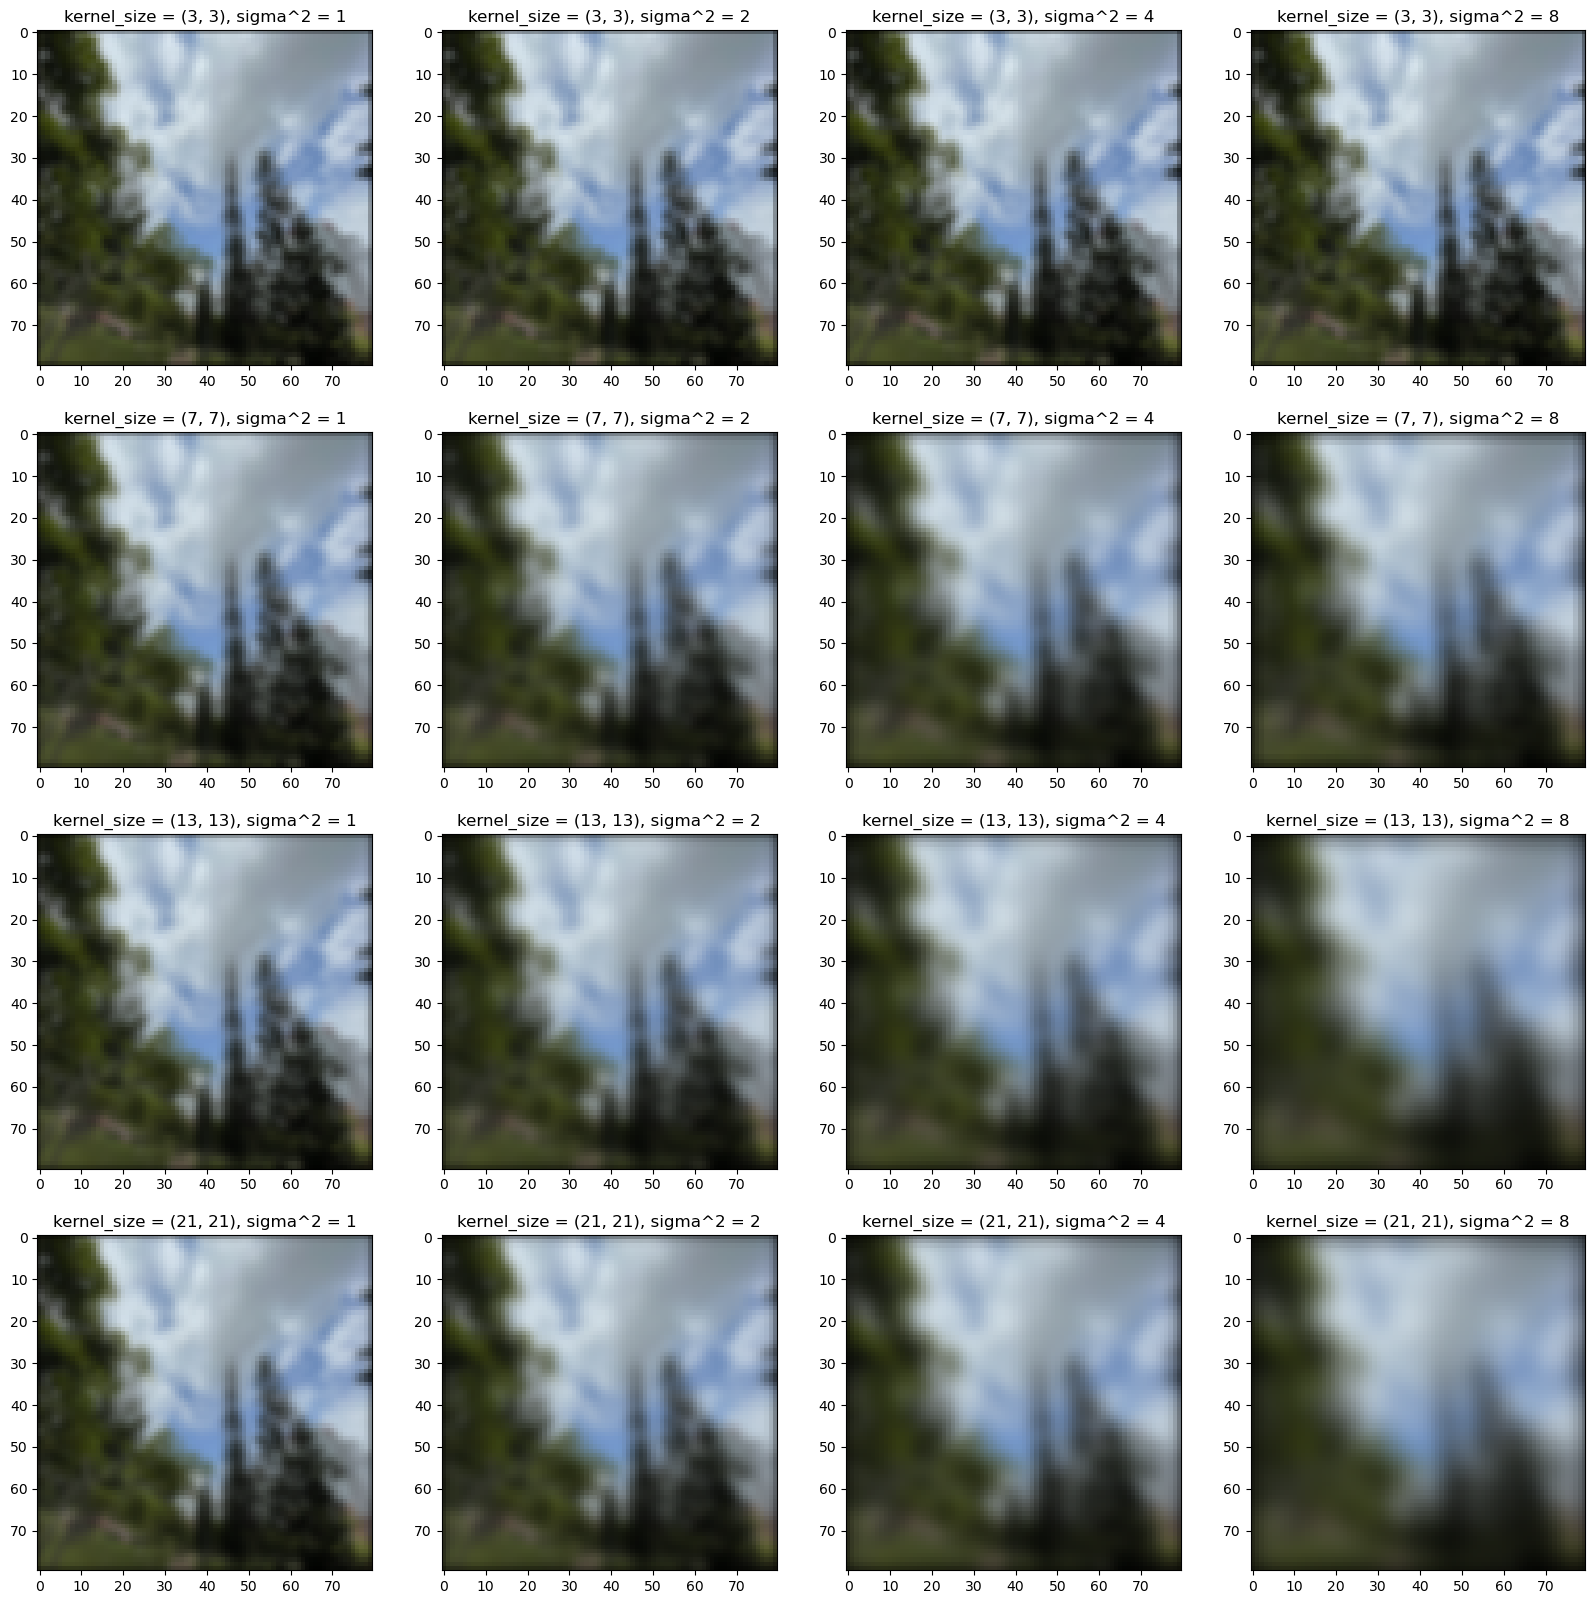

In [18]:
# # Testing with difference kernel size with difference sigma2
kernel_size_set = ((3,3), (7,7), (13,13),(21,21))
sigma2_set      = (1,2,4,8)

img_ind = 50
fig, ax = plt.subplots(len(kernel_size_set), len(sigma2_set),figsize=(20,20))

for i in range (len(kernel_size_set)):
    for j in range(len(sigma2_set)):
        img_arr_temp = img_tensors[img_ind].clone() * 255    # Get 1 sample image and convert the range back to 0 - 255
        
        conv_layer = torch.nn.Conv2d(1, 1, kernel_size_set[i], padding="same")
        conv_layer.weight = torch.nn.Parameter( torch.from_numpy(gaussian_filter(kernel_size_set[i], sigma2_set[j]))[None,None,:] )
        conv_layer.bias.data.fill_(0)
        
        with torch.no_grad():
            for k in range(3): # For each color channel
                img_arr_temp[k] = conv_layer((img_arr_temp[k])[None,None,:])
                
        ax[i,j].set_title(f"kernel_size = {kernel_size_set[i]}, sigma^2 = {sigma2_set[j]}")
        ax[i,j].imshow(img_arr_temp.permute(1,2,0).detach().to(torch.int32).numpy())

In [19]:
# Lastly, we decide to use the filter with size 7x7 with sigma2 = 4 in our dataset
if applied_Gaussian:
    kernel_size = (7,7)
    sigma2      = 4

    conv_layer = torch.nn.Conv2d(1, 1, kernel_size,padding="same")
    conv_layer.weight = torch.nn.Parameter(torch.from_numpy(gaussian_filter(kernel_size, sigma2))[None,None,:] )
    conv_layer.bias.data.fill_(0)

    for images in img_tensors:  # For each image
        with torch.no_grad():
            for k in range(3): # For each color channel
                images[k] = conv_layer((images[k])[None,None,:])

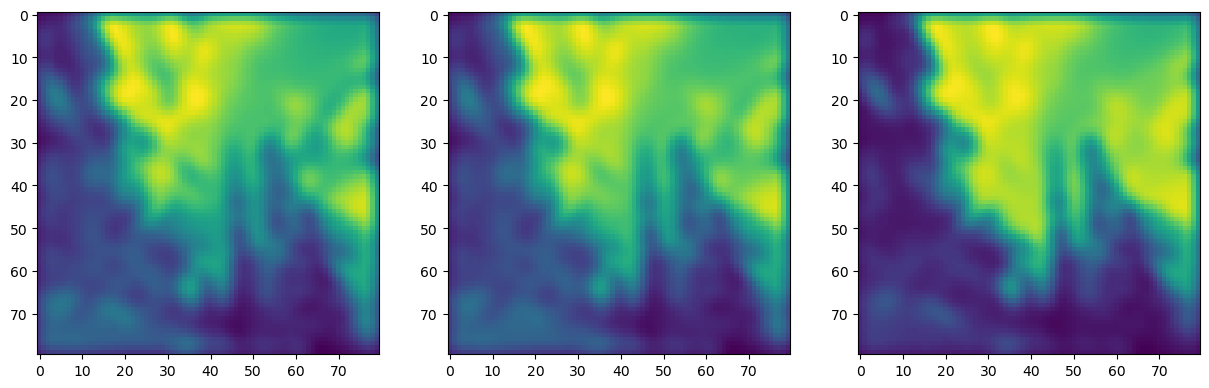

In [20]:
if applied_Gaussian:
    # Show the difference between Before filter and after filter (It remove the sharp details)
    fig, ax = plt.subplots(1, 3,figsize=(15,10))
    for i in range(3):
        ax[i].imshow(img_tensors[img_ind,i,:,:])

<a id = "T26"></a>
### ➟ Splitting the dataset into training, testing and validation

In [21]:
X_train, X_test, y_train, y_test = train_test_split(img_tensors, y, test_size=0.3, random_state=42, shuffle=True)

n_valid = int(len(X_test) * 0.3)
X_valid, X_test = X_test[:n_valid], X_test[n_valid:]
y_valid, y_test = y_test[:n_valid], y_test[n_valid:]

print("After splitting: X_train shape:",X_train.shape)
print("                 X_test  shape:",X_test.shape)
print("                 X_valid shape:",X_valid.shape)
print("                 y_train shape:",y_train.shape)
print("                 y_test  shape:",y_test.shape)
print("                 y_valid shape:",y_valid.shape)

After splitting: X_train shape: torch.Size([247, 3, 80, 80])
                 X_test  shape: torch.Size([75, 3, 80, 80])
                 X_valid shape: torch.Size([32, 3, 80, 80])
                 y_train shape: torch.Size([247, 3])
                 y_test  shape: torch.Size([75, 3])
                 y_valid shape: torch.Size([32, 3])


<a id = "T27"></a>
### ➟ Data Augmentation in training dataset
* Since our dataset is relatively small, we will applied data augmentation technique to double the training dataset
* In our case, we will applied flipping + rotation to generate more data 
* Note that we cannot do vertical flipping as it will make even a human hard to classify, therefore, we only do horizontal flipping 
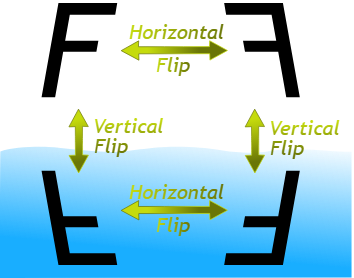

In [22]:
angle_list = [-20, -15, -10, -5, 5, 10, 15, 20]
length_al  = len(angle_list)

# Random Flipping with Rotation
def RandomFlipRotate(img):
    if np.random.randint(0,2):  # Have a chances to do horizontal flipping <--> 
        img = T.functional.hflip(img)
    return T.functional.rotate(img, angle_list[np.random.randint(0, length_al)])

In [23]:
# Do data augmentation to double the training dataset
X_train_trans = torch.zeros_like(X_train, dtype = torch.float32)
for i,img in enumerate(X_train):
    X_train_trans[i] = RandomFlipRotate(img)

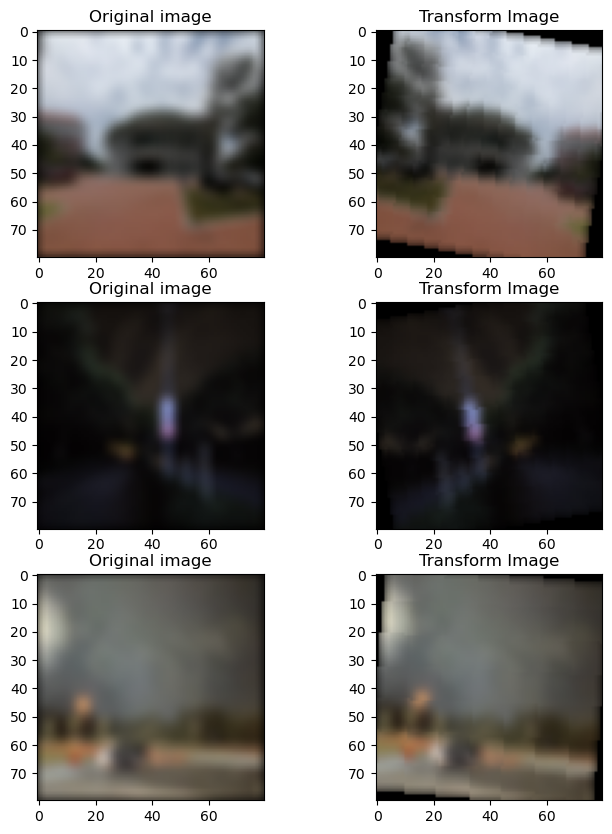

In [24]:
fig, ax = plt.subplots(3, 2,figsize=(8,10))

for i in range(3):
    ax[i,0].set_title("Original image")
    ax[i,0].imshow((X_train[i] * 255).permute(1,2,0).to(torch.int32).numpy())
    
    resize_img = re(img_path, new_size)
    ax[i,1].set_title("Transform Image")
    ax[i,1].imshow((X_train_trans[i] * 255).permute(1,2,0).to(torch.int32).numpy())
    plt.show

In [25]:
# Concatenate the dataset
print(X_train_trans.shape[0],"data will be added.")
X_train = torch.concat((X_train, X_train_trans),0)
y_train = torch.concat((y_train, y_train), 0)

# Random shuffle the dataset
idx = torch.randperm(X_train.shape[0])    # Random generate index from 0 to X_train.shape[0] - 1 
X_train = X_train[idx]
y_train = y_train[idx]

247 data will be added.


In [26]:
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: torch.Size([494, 3, 80, 80])
y_train shape: torch.Size([494, 3])


<a id = "T28"></a>
### ➟ Move the dataset to DataLoader

In [27]:
class Dataset_Class(Dataset):
    def __init__(self,x,y): # Initialize data, download, etc.
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.x.shape[0]

In [28]:
batch_size = 16
# Create Dataset
train_dataset = Dataset_Class(X_train, y_train)
test_dataset  = Dataset_Class(X_test, y_test)
valid_dataset = Dataset_Class(X_valid, y_valid)

# Create Dataset loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

<a id = "T3"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Feature Extraction using CNN Autoencoder
* In the layers of deep neural network, it will automatically help in feature extraction, 
* Ideally, a good feature extration can help the model train and converge faster.
* We will try out the model with autoencoder and without autoencoder and check the difference in performance

In [29]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.conv1   = nn.Conv2d(3, 32, kernel_size=(3, 3), stride = 1,padding = "same")
        self.conv2   = nn.Conv2d(32, 16, kernel_size=(3, 3), stride = 1, padding = "same")
        self.conv3   = nn.Conv2d(16, 4, kernel_size=(3, 3), stride = 1, padding = "same")
        self.conv4   = nn.Conv2d(4, 3, kernel_size=(3, 3), stride = 1, padding = "same")
        
        self.batchN1 = nn.BatchNorm2d(32)
        self.batchN2 = nn.BatchNorm2d(16)
        self.batchN3 = nn.BatchNorm2d(4)
        self.batchN4 = nn.BatchNorm2d(3)
        
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.conv_T1 = nn.ConvTranspose2d(3, 4, kernel_size=(2,2), stride = 2)
        self.conv_T2 = nn.ConvTranspose2d(4, 16, kernel_size=(2,2), stride = 2)
        self.conv_T3 = nn.ConvTranspose2d(16, 32, kernel_size=(2,2), stride = 2)
        self.conv_T4 = nn.ConvTranspose2d(32, 3, kernel_size=(2,2), stride = 2)
        self.sigmoid = nn.Sigmoid()   # To make the output have range from 0 - 1
        
        self.apply(self._init_weights)
        torch.nn.init.xavier_normal_(self.conv_T4.weight, gain = nn.init.calculate_gain('sigmoid'))
        
        self.encoder = nn.Sequential(self.conv1, self.batchN1, self.relu, self.maxpool,  # After maxpool, Shape = (batch_size, 32, 40, 40)
                                     self.conv2, self.batchN2, self.relu, self.maxpool,  # After maxpool, Shape = (batch_size, 16, 20, 20)
                                     self.conv3, self.batchN3, self.relu, self.maxpool,  # After maxpool, Shape = (batch_size, 4, 10, 10)
                                     self.conv4, self.batchN4, self.relu, self.maxpool)  # After maxpool, Shape = (batch_size, 3, 5, 5)
        
        self.decoder = nn.Sequential(self.conv_T1, self.batchN3, self.relu,   # After conv_T1, Shape = (batch_size, 4, 10, 10)
                                     self.conv_T2, self.batchN2, self.relu,   # After conv_T1, Shape = (batch_size, 16, 20, 20)
                                     self.conv_T3, self.batchN1, self.relu,   # After conv_T1, Shape = (batch_size, 32, 40, 40)
                                     self.conv_T4, self.sigmoid)              # After conv_T1, Shape = (batch_size, 3, 80, 80)
        
        
        
    # For initialize the weight
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.xavier_normal_(module.weight, gain = nn.init.calculate_gain('relu'))
            if module.bias is not None:  # Initialize the bias as 1
                module.bias.data.fill_(1) 
#                 torch.nn.init.constant_(module.bias, 1) # OR we can initializa like this
#                 torch.nn.init.ones_(module.bias)        # OR 
                

    def forward(self, x):     # Original       shape = [batch_size, 3, 80, 0]
        x = self.encoder(x)   # After encoder, shape = [batch_size, 3, 5, 5]
        x = self.decoder(x)   # After decoder, shape = [batch_size, 3, 80, 80]
        return x


In [32]:
num_epochs     = 200
lr_set         = [0.0005, 0.001, 0.005, 0.01]    # Learning rate set
lambda_set     = [0, 0.05, 0.1]                  # Weight decay (lambda) set
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
num_training   = len(lr_set) * len(lambda_set)

print("The device used =",device)
print("Number of running the training: ", num_training)

The device used = cuda
Number of running the training:  12


In [33]:
CNNA_model   = CNNAutoencoder().to(device)
total_params = sum(param.numel() for param in CNNA_model.parameters())
print("Total number of parameter in CNN Autoencoder =",total_params)
CNNA_model.to("cpu")

Total number of parameter in CNN Autoencoder = 9112


CNNAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_T1): ConvTranspose2d(3, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv_T2): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv_T3): ConvTranspose2d(16, 32, kernel_size=(2, 2), strid

<a id = "T31"></a>
### ➟ Training

In [34]:
%%time
os.makedirs(f"Models{convert_RGB2HSV}{applied_Gaussian}", exist_ok=True)
batch_Tloss, batch_Vloss, batch_epoch = [], [], []
batch_best_Tloss, batch_best_Vloss = np.full(num_training, 10, dtype = np.float32), np.full(num_training, 10, dtype = np.float32)

for i, lambda_ in enumerate(lambda_set):
    for j, lr in enumerate(lr_set):
        try:
            CNNA_model.to("cpu")
        except:
            pass

        # Create a CNN model
        CNNA_model   = CNNAutoencoder().to(device)

        # Loss and optimizer
        loss      = nn.L1Loss()  # Mean absolute error
        optimizer = torch.optim.Adam(CNNA_model.parameters(), lr=lr, weight_decay=lambda_)

        print("> > > For lambda =",lambda_,"Learning rate =",lr)
        batch_Tloss_temp, batch_Vloss_temp = [], []
        MAX_LIC         = 15   # Maximum Validation Loss Increase Count 
        LIC             = 0    # Loss Increase Count

        for epoch in range(num_epochs): # Epochs loop

            train_loss, sum_train_loss, valid_loss = 0, 0, 0
            # Training
            CNNA_model.train()  # Change the batchNormalization layer to training mode
            for images, label in train_loader:
                images = images.to(device) 

                outputs    = CNNA_model(images)
                train_loss = loss(outputs, images)   # In autoencoder, target output = input

                optimizer.zero_grad()            # Clear the gradient
                train_loss.backward()            # Compute the gradient
                optimizer.step()                 # Update the gradient

                sum_train_loss    += train_loss.cpu().detach().item() * label.shape[0]
                images = images.to("cpu")

            sum_train_loss /= X_train.shape[0]
            batch_Tloss_temp.append(sum_train_loss)

            # Test the performance on the validation dataset
            CNNA_model.eval()   # Change the batchmalization layer to evaluation mode
            with torch.no_grad():
                for image_, _ in valid_loader:
                    image_ = image_.to(device) 
                    outputs = CNNA_model(image_)

                    valid_loss += loss(outputs, image_).cpu().item() * image_.shape[0]
                    image_ = image_.to("cpu")
            valid_loss /= X_valid.shape[0]
            batch_Vloss_temp.append(valid_loss)
            
            # Save the first loss to prevent the scenario (If the loss keep increasing from first epoch, best_loss will be 10)
            if batch_best_Vloss[i*len(lr_set)+j] == 10:  
                batch_best_Vloss[i*len(lr_set)+j] = valid_loss
                batch_best_Tloss[i*len(lr_set)+j] = sum_train_loss
                
            # if (epoch+1) % 10 == 0: 
            #     print(f"Lambda: {lambda_}, Epoch = {epoch + 1}, Training loss: {sum_train_loss:.3f}, Validation loss: {valid_loss:.3f}")

            if valid_loss > batch_best_Vloss[i+j]: # If current loss > previous loss (previous is better)
                LIC += 1
            else:
                batch_best_Vloss[i*len(lr_set)+j] = valid_loss
                batch_best_Tloss[i*len(lr_set)+j] = sum_train_loss
                
                torch.save(CNNA_model.state_dict(), f"Models{convert_RGB2HSV}{applied_Gaussian}/CNNA_{lambda_}_{lr}.pt") # Save a copy of current best model
                LIC = 0

            if LIC == MAX_LIC:
                print("The validation loss is continuously increase for",LIC,"times at epoch",epoch+1,"so the training stop")
                print(f" Epoch = {epoch + 1}, Training loss: {sum_train_loss:.3f}, Validation loss: {valid_loss:.3f}")
                batch_epoch.append(epoch+1)
                break
        else:
            batch_epoch.append(num_epochs)
            print(f"Epoch = {num_epochs}, Training loss: {sum_train_loss:.3f}, Validation loss: {valid_loss:.3f}")
        
        print()
        batch_Tloss.append(batch_Tloss_temp)
        batch_Vloss.append(batch_Vloss_temp)
        CNNA_model.to("cpu")

> > > For lambda = 0 Learning rate = 0.0005
The validation loss is continuously increase for 15 times at epoch 31 so the training stop
 Epoch = 31, Training loss: 0.082, Validation loss: 0.186

> > > For lambda = 0 Learning rate = 0.001
The validation loss is continuously increase for 15 times at epoch 29 so the training stop
 Epoch = 29, Training loss: 0.077, Validation loss: 0.269

> > > For lambda = 0 Learning rate = 0.005
The validation loss is continuously increase for 15 times at epoch 22 so the training stop
 Epoch = 22, Training loss: 0.072, Validation loss: 0.184

> > > For lambda = 0 Learning rate = 0.01
The validation loss is continuously increase for 15 times at epoch 26 so the training stop
 Epoch = 26, Training loss: 0.073, Validation loss: 0.186

> > > For lambda = 0.05 Learning rate = 0.0005
The validation loss is continuously increase for 15 times at epoch 47 so the training stop
 Epoch = 47, Training loss: 0.167, Validation loss: 0.252

> > > For lambda = 0.05 Learnin

In [35]:
# Show the loss using 2D graph
def plotL2Graph(ax, title, loss, lambda_set, lr_set, i):
    ax[i].set_title(title)
    for num in range(len(lambda_set) * len(lr_set)):
        ax[i].plot(range(len(loss[num])), loss[num], label=f"lambda:{lambda_set[num // len(lr_set)]}, lr:{lr_set[num % len(lr_set)]}")
        ax[i].legend()

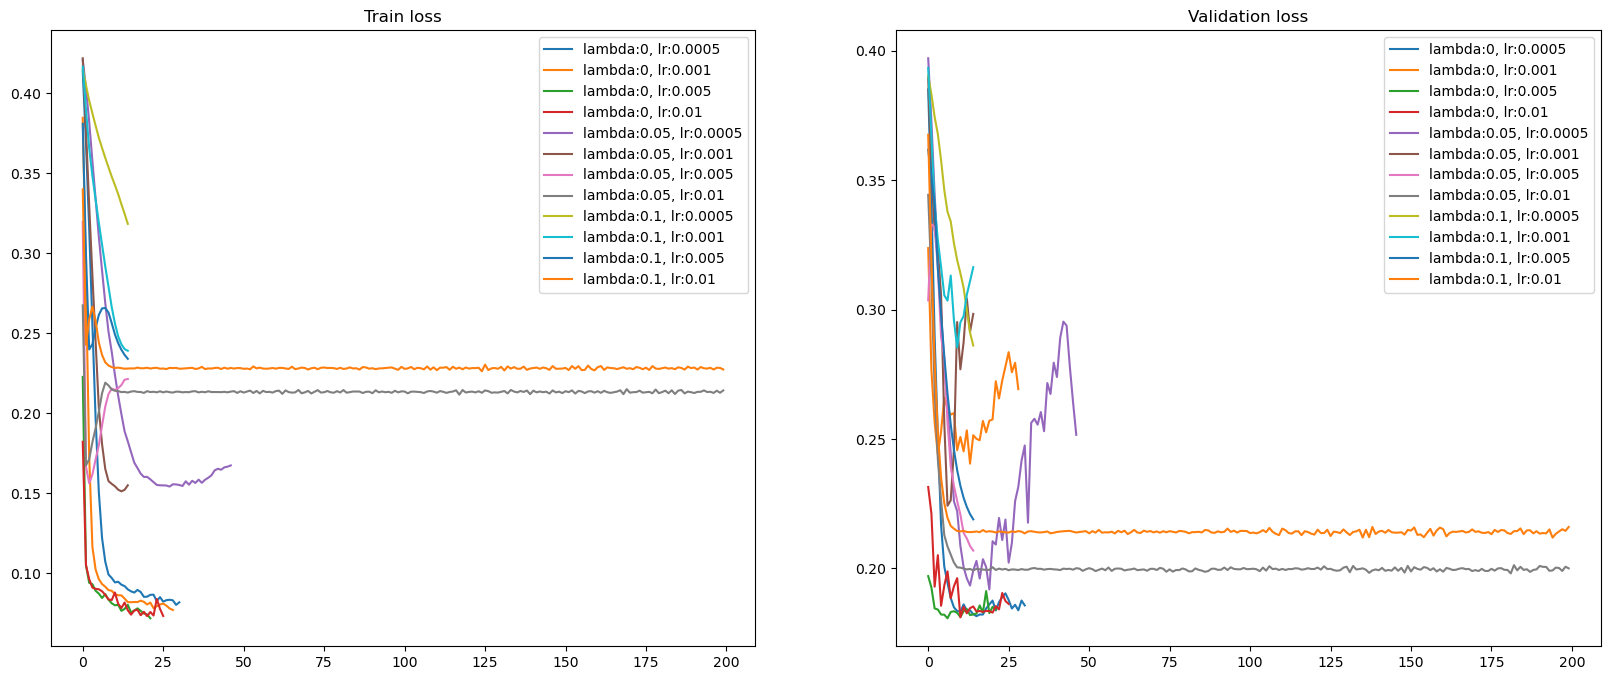

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plotL2Graph(ax, "Train loss", batch_Tloss, lambda_set, lr_set, 0)
plotL2Graph(ax, "Validation loss", batch_Vloss, lambda_set, lr_set, 1)

In [37]:
# Show the best loss (follow validation loss) using dataframe
df = pd.DataFrame(np.vstack((batch_epoch,
                             np.array([[lambda_] * len(lr_set) for lambda_ in lambda_set]).reshape(-1),
                             lr_set * len(lambda_set),
                             batch_best_Tloss, batch_best_Vloss)).T, 
                  columns = ["Epoch", "Lambda", "lr", "Train loss", "Best Validation loss"])
pd.options.display.max_rows = num_training
df.head(num_training)

,Epoch,Lambda,lr,Train loss,Best Validation loss
0,31.0,0.00,0.0005,0.088789,0.181588
1,29.0,0.00,0.0010,0.084286,0.240489
2,22.0,0.00,0.0050,0.084619,0.180758
3,26.0,0.00,0.0100,0.088069,0.181098
4,47.0,0.05,0.0005,0.154585,0.217690
5,15.0,0.05,0.0010,0.421697,0.389501
6,15.0,0.05,0.0050,0.319500,0.303602
7,200.0,0.05,0.0100,0.214231,0.200042
8,15.0,0.10,0.0005,0.415024,0.390420
9,15.0,0.10,0.0010,0.416467,0.393371


<a id = "b1"></a>

In [38]:
# Among them, the model with lowest validation loss is choosen
batch_best_Vloss = np.array(batch_best_Vloss)
idx = np.where(batch_best_Vloss == np.min(batch_best_Vloss))[0][0]
BEST_CNNA_PATH = f"Models{convert_RGB2HSV}{applied_Gaussian}/CNNA_{lambda_set[idx // len(lr_set)]}_{lr_set[idx % len(lr_set)]}.pt"
                                                                          
print(f"The model with lowest validation loss is at index {idx} with lr = {lr_set[idx % len(lr_set)]} lambda = {lambda_set[idx // len(lr_set)]}" )
print("Therefore, the best model path =", BEST_CNNA_PATH)

The model with lowest validation loss is at index 2 with lr = 0.005 lambda = 0
Therefore, the best model path = Models01/CNNA_0_0.005.pt


<a id = "T32"></a>
### ➟ Use model to reconstruct the image

In [39]:
def plot_image(model,X, num_image_show = 2):
    fig, ax = plt.subplots(num_image_show, 2,figsize=(8,10))

    for i in range(num_image_show):
        ax[i,0].set_title(f"Image {i} Before")
        ax[i,0].imshow(X[i].permute(1,2,0))
        ax[i,1].set_title(f"Image {i} After")
        
        temp = X[i].to(device)
        ax[i,1].imshow(model(temp[None,:])[0].cpu().detach().permute(1,2,0).numpy())
        temp = temp.to("cpu")

In [40]:
# Load the best CNN Autoencoder model
CNNA_model = CNNAutoencoder().to(device)
CNNA_model.load_state_dict(torch.load(BEST_CNNA_PATH))
for param in CNNA_model.parameters():
    param.requires_grad = False

For training dataset


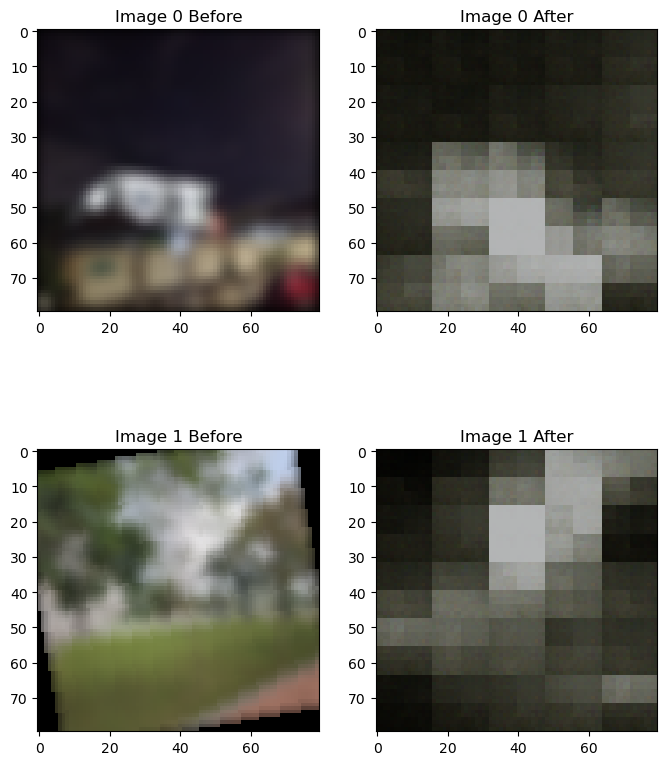

In [41]:
print("For training dataset")
plot_image(CNNA_model, X_train)

For testing dataset


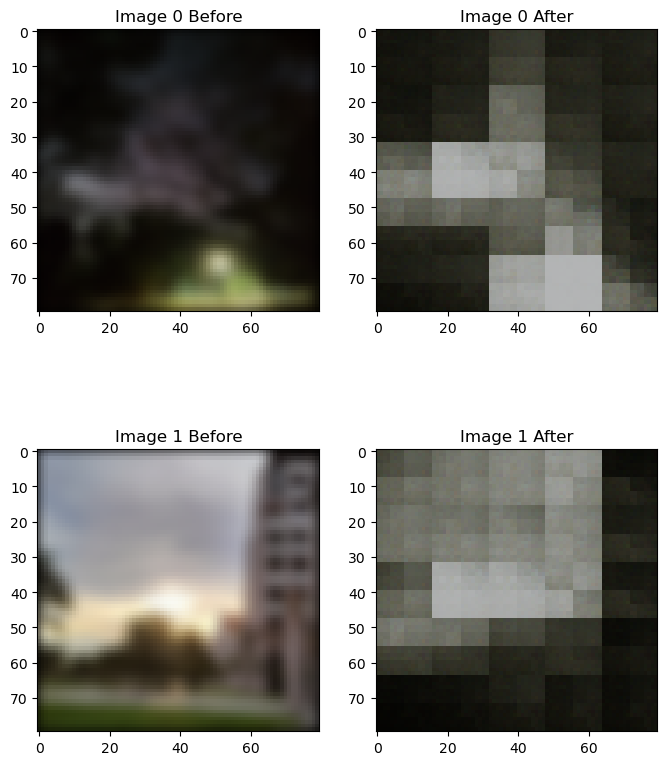

In [42]:
print("For testing dataset")
plot_image(CNNA_model, X_test)

<a id = "T4"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Day/Dusk/Night Classification Model

In [43]:
# Building the model 
class NeuralNet(nn.Module):
    def __init__(self, enable_autoencoder = True, droupout_rate = 0.3):
        super(NeuralNet, self).__init__()
        self.enable_autoencoder = enable_autoencoder
        
        self.conv1   = nn.Conv2d(3, 32, kernel_size=(3, 3), stride = 1,padding = 1)
        self.conv2   = nn.Conv2d(32, 16, kernel_size=(3, 3), stride = 1, padding = 1)
        self.conv3   = nn.Conv2d(16, 4, kernel_size=(3, 3), stride = 1, padding = 1)
        self.conv4   = nn.Conv2d(4, 3, kernel_size=(3, 3), stride = 1, padding = 1)
        
        self.batchN1 = nn.BatchNorm2d(32)
        self.batchN2 = nn.BatchNorm2d(16)
        self.batchN3 = nn.BatchNorm2d(4)
        self.batchN4 = nn.BatchNorm2d(3)
        
        if enable_autoencoder:
            self.l1  = nn.Linear(150, 64) 
        else:
            self.l1  = nn.Linear(75, 64)
        
        self.l2      = nn.Linear(64, 32)
        self.l3      = nn.Linear(32, 3)
        
        self.apply(self._init_weights)
        torch.nn.init.xavier_normal_(self.l3.weight, gain = 1)  # Initialize the last layer with gain = 1 as it is using softmax activation function
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.droupout= nn.Dropout(p=droupout_rate)
        self.relu    = nn.ReLU()
        
    # For initialize the weight
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight, gain = nn.init.calculate_gain('relu'))
            if module.bias is not None:  # Initialize the bias as 1
                module.bias.data.fill_(1) 

                
    def forward(self, x):
        CNN_out = self.maxpool(self.relu(self.batchN1(self.conv1(x))))
        CNN_out = self.maxpool(self.relu(self.batchN2(self.conv2(CNN_out))))
        CNN_out = self.maxpool(self.relu(self.batchN3(self.conv3(CNN_out))))  
        CNN_out = self.maxpool(self.relu(self.batchN4(self.conv4(CNN_out))))  # Shape = (batch_size, 3, 5, 5)
        CNN_out = torch.flatten(CNN_out , 1)                                  # Shape = (batch_size, 75)
        
        if self.enable_autoencoder:
            encoder_out = CNNA_model.encoder(x)            # Shape = (batch_size, 3, 5, 5)
            encoder_out = torch.flatten(encoder_out, 1)    # Shape = (batch_size, 75)
            x = torch.cat((CNN_out, encoder_out), 1)       # Shape = (batch_size, 150)
            x = self.relu(self.l1(x))                      # Shape = (batch_size, 64)
        else:
            x = self.relu(self.l1(CNN_out))                # Shape = (batch_size, 64)
        x = self.droupout(x)  
        x = self.relu(self.l2(x))                          # Shape = (batch_size, 32)
        x = self.droupout(x)
        out = self.l3(x)   
        
        return out

<a id = "T41"></a>
### ➟ Training

In [44]:
def training(num_epochs, learning_rate, weight_decay, enable_autoencoder, 
             droupout_rate, MAX_ADC, device, i, batch_best_loss, batch_best_accu):
    print(f"> > > For NeuralNet_{i}.pt")
    # Model building
    model        = NeuralNet(enable_autoencoder = enable_autoencoder, droupout_rate = droupout_rate).to(device)
    total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    print("Total number of parameter in CNN =",total_params)

    # Loss and optimizer
    loss      = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)   
    
    # (batch of train loss, accuracy) and (batch of validation loss and accuracy)
    batch_Tloss, batch_Taccu, batch_Vloss, batch_Vaccu = [], [], [], []
    ADC             = 0   # Accuracy Decrease Count
    prev_best_Vaccu = 0   # Previous best validation accuracy

    for epoch in range(num_epochs): # Epochs loop
        sum_train_loss, valid_loss, num_correct_train, num_correct_valid = 0, 0, 0, 0

        model.train()  # To activate the dropout layer
        for images, label in train_loader:

            images = images.to(device) 
            label  = label.to(device) 

            outputs    = model(images)
            train_loss = loss(outputs, label)

            optimizer.zero_grad()   # Clear the gradient
            train_loss.backward()   # Compute the gradient
            optimizer.step()        # Update the gradient

            num_correct_train += (torch.argmax(outputs, axis = 1) == torch.argmax(label, axis = 1)).sum()
            sum_train_loss    += train_loss.cpu().detach().item() * label.shape[0]

        sum_train_loss /= X_train.shape[0]
        train_accuracy  = num_correct_train.cpu().detach().item() / X_train.shape[0]
        batch_Tloss.append(sum_train_loss)
        batch_Taccu.append(train_accuracy)

        # Test the performance on the validation dataset
        model.eval()   # Change the batchmalization layer to evaluation mode
        with torch.no_grad():
            for image_, label_ in valid_loader:
                image_  = image_.to(device) 
                label_  = label_.to(device)
                outputs = model(image_)

                valid_loss        += loss(outputs, label_).cpu().item() * label_.shape[0]
                num_correct_valid += (torch.argmax(outputs, axis = 1) == torch.argmax(label_, axis = 1)).sum()


        valid_loss    /= X_valid.shape[0]
        valid_accuracy = num_correct_valid.cpu().detach().item() / X_valid.shape[0]
        batch_Vloss.append(valid_loss)
        batch_Vaccu.append(valid_accuracy)

        # if (epoch+1) % 10 == 0: 
            # print(f"Epoch = {epoch + 1:<4}, Training loss: {sum_train_loss:.3f}, Validation loss: {valid_loss:.3f}")
            # print(f"              Training accu: {train_accuracy:.3f}, Validation accu: {valid_accuracy:.3f}")

        if valid_accuracy < prev_best_Vaccu: # If current accuracy < previous accuracy (previous is better)
            ADC += 1
        else:
            prev_best_Vaccu = valid_accuracy
            batch_best_loss[0, i] = valid_loss
            batch_best_loss[1, i] = sum_train_loss
            batch_best_accu[0, i] = valid_accuracy
            batch_best_accu[1, i] = train_accuracy
            
            torch.save(model.state_dict(), f"Models{convert_RGB2HSV}{applied_Gaussian}/NeuralNet_{i}.pt")  # Save a copy of weight of current best model
            ADC = 0

        if ADC == MAX_ADC:
            print("The validation accuracy is continuously decreasing for",ADC,"times at epoch",epoch+1,"so the training stop")
            print(f"Epochs:{epoch + 1}, lr:{learning_rate}, w_decay:{weight_decay}", end = " ")
            print(f"autoencoder:{enable_autoencoder}, droupout_rate:{droupout_rate}, MAX_ADC:{MAX_ADC}, device:{device}")
            print(f"train_loss: {train_loss:.3f}, train_acc: {train_accuracy:.3f}, val_loss:{valid_loss:.3f}, val_acc:{valid_accuracy:.3f}")
            params_dict = {"Epochs" :epoch+1, "lr":learning_rate, "w_decay" : weight_decay, "autoencoder":enable_autoencoder, "droupout_rate" : droupout_rate , "MAX_ADC" : MAX_ADC}
            break
    else:
        print(f"Epochs:{epoch + 1}, lr:{learning_rate}, w_decay:{weight_decay}", end = " ")
        print(f"autoencoder:{enable_autoencoder}, droupout_rate:{droupout_rate}, MAX_ADC:{MAX_ADC}, device:{device}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_accuracy:.3f}, val_loss:{valid_loss:.3f}, val_acc:{valid_accuracy:.3f}")    
        params_dict = {"Epochs" :num_epochs, "lr":learning_rate, "w_decay" : weight_decay, "autoencoder":enable_autoencoder, "droupout_rate" : droupout_rate , "MAX_ADC" : MAX_ADC}
    model.to("cpu")  # Move model to cpu before end the function
    return batch_Tloss, batch_Taccu, batch_Vloss, batch_Vaccu, params_dict

In [45]:
# Hyperparameter
num_epochs         = 150
learning_rate      = [0.0001, 0.0005]
weight_decay       = [0, 0.05, 0.1]
enable_autoencoder = [True, False]
droupout_rate      = [0, 0.2, 0.4]
MAX_ADC            = [3, 5]           # Maximum Validation Accuracy Decrease Count 
n_training         = len(learning_rate) * len(weight_decay) * len(enable_autoencoder) * len(droupout_rate) * len(MAX_ADC)
device             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device used =",device)
print("Number of times to train: ",n_training)

Device used = cuda
Number of times to train:  72


In [46]:
%%time
batch_best_loss = np.full((2,n_training), 10, dtype = np.float32)
batch_best_accu = np.zeros((2,n_training), dtype = np.float32)
                           
batch_Tloss, batch_Taccu, batch_Vloss, batch_Vaccu = [],[],[],[]
params_dict = {f"NeuralNet_{i}" :None for i in range(n_training)}
iteration = 0

for lr in learning_rate:
    for wd in weight_decay:
        for ea in enable_autoencoder:
            for dr in droupout_rate:
                for max_adc in MAX_ADC:
                    Tloss, Taccu, Vloss, Vaccu, params_ =training(num_epochs, lr, wd, ea, dr, max_adc, device, 
                                                                  iteration, batch_best_loss, batch_best_accu)
                    params_dict[f"NeuralNet_{iteration}"] = params_
                    batch_Tloss.append(Tloss)
                    batch_Vloss.append(Vloss)
                    batch_Taccu.append(Taccu)
                    batch_Vaccu.append(Vaccu)
                    iteration += 1
                    print("")

> > > For NeuralNet_0.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 3 times at epoch 30 so the training stop
Epochs:29, lr:0.0001, w_decay:0 autoencoder:True, droupout_rate:0, MAX_ADC:3, device:cuda
train_loss: 0.184, train_acc: 0.964, val_loss:0.197, val_acc:0.906

> > > For NeuralNet_1.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 5 times at epoch 26 so the training stop
Epochs:25, lr:0.0001, w_decay:0 autoencoder:True, droupout_rate:0, MAX_ADC:5, device:cuda
train_loss: 0.198, train_acc: 0.945, val_loss:0.301, val_acc:0.875

> > > For NeuralNet_2.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 3 times at epoch 20 so the training stop
Epochs:19, lr:0.0001, w_decay:0 autoencoder:True, droupout_rate:0.2, MAX_ADC:3, device:cuda
train_loss: 0.447, train_acc: 0.727, val_loss:0.439, val_acc:0.844

> > > For NeuralNet_3.pt
Total number 

The validation accuracy is continuously decreasing for 3 times at epoch 10 so the training stop
Epochs:9, lr:0.0001, w_decay:0.1 autoencoder:True, droupout_rate:0.2, MAX_ADC:3, device:cuda
train_loss: 0.329, train_acc: 0.704, val_loss:0.463, val_acc:0.781

> > > For NeuralNet_27.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 5 times at epoch 32 so the training stop
Epochs:31, lr:0.0001, w_decay:0.1 autoencoder:True, droupout_rate:0.2, MAX_ADC:5, device:cuda
train_loss: 0.158, train_acc: 0.874, val_loss:0.227, val_acc:0.875

> > > For NeuralNet_28.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 3 times at epoch 7 so the training stop
Epochs:6, lr:0.0001, w_decay:0.1 autoencoder:True, droupout_rate:0.4, MAX_ADC:3, device:cuda
train_loss: 1.851, train_acc: 0.524, val_loss:0.663, val_acc:0.719

> > > For NeuralNet_29.pt
Total number of parameter in CNN = 18164
The validation accuracy is c

The validation accuracy is continuously decreasing for 3 times at epoch 24 so the training stop
Epochs:23, lr:0.0005, w_decay:0.05 autoencoder:True, droupout_rate:0.4, MAX_ADC:3, device:cuda
train_loss: 0.089, train_acc: 0.909, val_loss:0.235, val_acc:0.875

> > > For NeuralNet_53.pt
Total number of parameter in CNN = 18164
The validation accuracy is continuously decreasing for 5 times at epoch 34 so the training stop
Epochs:33, lr:0.0005, w_decay:0.05 autoencoder:True, droupout_rate:0.4, MAX_ADC:5, device:cuda
train_loss: 0.171, train_acc: 0.915, val_loss:0.201, val_acc:0.938

> > > For NeuralNet_54.pt
Total number of parameter in CNN = 13364
The validation accuracy is continuously decreasing for 3 times at epoch 17 so the training stop
Epochs:16, lr:0.0005, w_decay:0.05 autoencoder:False, droupout_rate:0, MAX_ADC:3, device:cuda
train_loss: 0.131, train_acc: 0.970, val_loss:0.177, val_acc:0.938

> > > For NeuralNet_55.pt
Total number of parameter in CNN = 13364
The validation accuracy

<a id = "b2"></a>

In [47]:
# 0.00001 * train_accuracy + validation_accuracy  (if validation accuracy same, train accuracy only significant)
best_average_TVaccu = 0.00001 * batch_best_accu[1] + batch_best_accu[0] 
sorted_Vaccu        = np.sort(best_average_TVaccu)

# Get the top 10 best model based best validation accuracy, if validation accuracy same, select the one with higher training accuracy
temp             = [np.where(best_average_TVaccu == sorted_Vaccu[-i]) for i in range(1,11) if sorted_Vaccu[-i] != sorted_Vaccu[-i+1]]
index_best_model = []
for i in temp:
    index_best_model += [j for j in i[0]]
index_best_model = index_best_model[:10] 
enable_autoencoder_ls = [params_dict[f'NeuralNet_{i}']['autoencoder'] for i in index_best_model]

print("The top 10 best model are:", index_best_model)
print("  with enable autoencoder:", enable_autoencoder_ls)

The top 10 best model are: [6, 45, 60, 54, 44, 47, 59, 18, 25, 42]
  with enable autoencoder: [False, False, True, False, False, False, False, False, True, False]


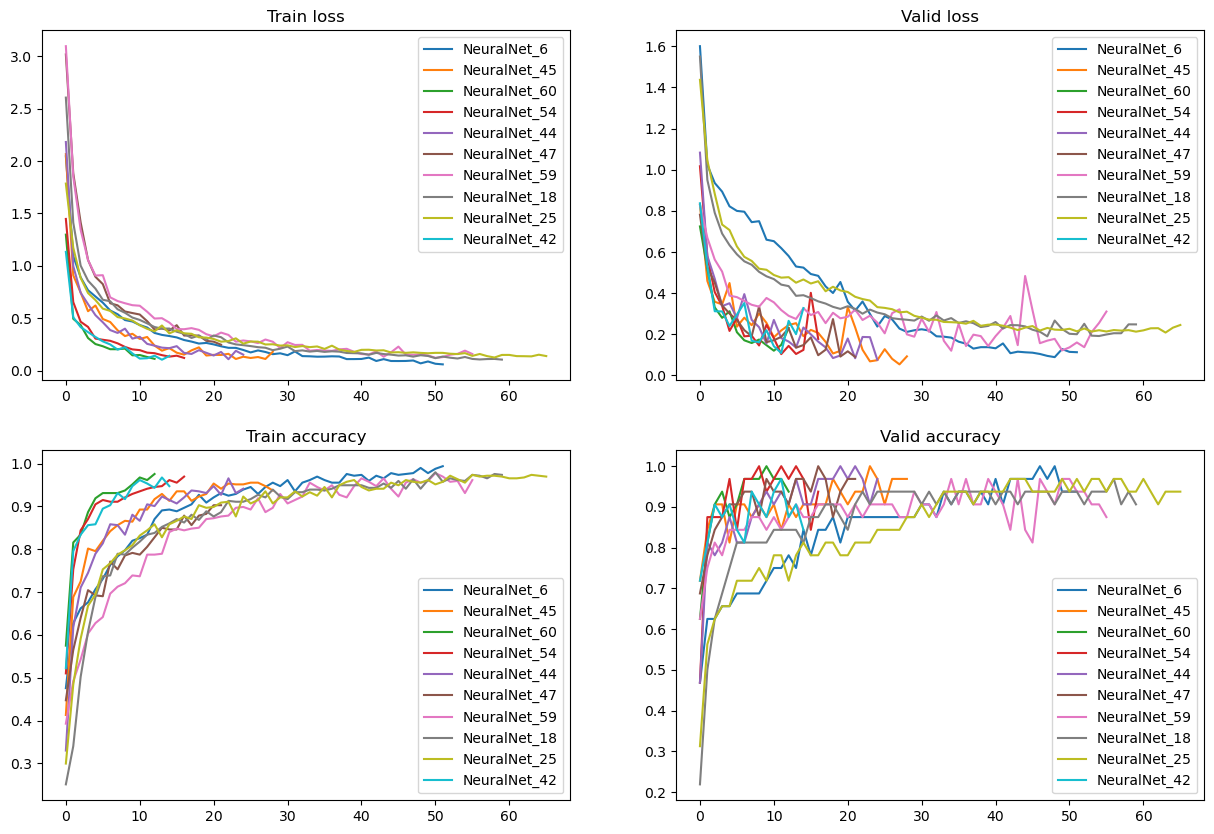

In [48]:
fig, ax = plt.subplots(2, 2,figsize=(15,10))

def plot_graph(title, batch_data, i, j):
    ax[i,j].set_title(title)
    for k in index_best_model: 
        ax[i,j].plot(range(len(batch_data[k])), batch_data[k], label = f"NeuralNet_{k}")
    ax[i,j].legend()

plot_graph("Train loss", batch_Tloss, 0,0)
plot_graph("Valid loss", batch_Vloss, 0,1)
plot_graph("Train accuracy", batch_Taccu, 1,0)
plot_graph("Valid accuracy", batch_Vaccu, 1,1)

* Figure above show the top 10 best model, the model at first row will be the best model, the model at second row will be the second best model,...

In [49]:
columns    = ["Epochs", "lr", "w_decay", "autoencoder", "droupout_rate", "MAX_ADC"]
all_params = []

for col in columns:
    all_params.append([params_dict[f'NeuralNet_{i}'][col] for i in range(n_training)])
    

df = pd.DataFrame(np.vstack((all_params, batch_best_loss, batch_best_accu)).T, 
                  columns = columns + ["Validation loss", "Train loss", "Best Validation accuracy", "Train accuracy"])

pd.options.display.max_rows = n_training
df.head(n_training)

,Epochs,lr,w_decay,autoencoder,droupout_rate,MAX_ADC,Validation loss,Train loss,Best Validation accuracy,Train accuracy
0,30.0,0.0001,0.00,1.0,0.0,3.0,0.228664,0.146871,0.93750,0.949393
1,26.0,0.0001,0.00,1.0,0.0,5.0,0.224721,0.190209,0.90625,0.937247
2,20.0,0.0001,0.00,1.0,0.2,3.0,0.465945,0.704494,0.87500,0.722672
3,45.0,0.0001,0.00,1.0,0.2,5.0,0.294559,0.348869,0.90625,0.868421
4,14.0,0.0001,0.00,1.0,0.4,3.0,0.538390,1.171881,0.78125,0.625506
5,105.0,0.0001,0.00,1.0,0.4,5.0,0.216350,0.289329,0.93750,0.896761
6,52.0,0.0001,0.00,0.0,0.0,3.0,0.088974,0.069469,1.00000,0.989879
7,29.0,0.0001,0.00,0.0,0.0,5.0,0.332725,0.220205,0.87500,0.927126
8,17.0,0.0001,0.00,0.0,0.2,3.0,0.531598,0.631506,0.81250,0.751012
9,48.0,0.0001,0.00,0.0,0.2,5.0,0.261500,0.375880,0.93750,0.844130


In [50]:
# Show the top 10 best model in validation dataset
df.iloc[index_best_model]

,Epochs,lr,w_decay,autoencoder,droupout_rate,MAX_ADC,Validation loss,Train loss,Best Validation accuracy,Train accuracy
6,52.0,0.0001,0.00,0.0,0.0,3.0,0.088974,0.069469,1.00000,0.989879
45,29.0,0.0005,0.00,0.0,0.2,5.0,0.068406,0.111226,1.00000,0.951417
60,13.0,0.0005,0.10,1.0,0.0,3.0,0.147145,0.146127,1.00000,0.951417
54,17.0,0.0005,0.05,0.0,0.0,3.0,0.104295,0.147798,1.00000,0.947368
44,25.0,0.0005,0.00,0.0,0.2,3.0,0.083563,0.178349,1.00000,0.927126
47,22.0,0.0005,0.00,0.0,0.4,5.0,0.098214,0.334839,1.00000,0.878542
59,56.0,0.0005,0.05,0.0,0.4,5.0,0.136354,0.122461,0.96875,0.977733
18,60.0,0.0001,0.05,0.0,0.0,3.0,0.205140,0.106690,0.96875,0.971660
25,66.0,0.0001,0.10,1.0,0.0,5.0,0.219095,0.150030,0.96875,0.965587
42,15.0,0.0005,0.00,0.0,0.0,3.0,0.109088,0.118387,0.96875,0.953441


<a id = "T42"></a>
### ➟ Evaluating on test dataset

In [51]:
batch_accu = []
for i in range(len(batch_Tloss)):
    try:
        load_model.to("cpu")
    except:
        pass
    load_model = NeuralNet(enable_autoencoder = params_dict[f'NeuralNet_{i}']['autoencoder']).to(device)
    load_model.load_state_dict(torch.load(f"Models{convert_RGB2HSV}{applied_Gaussian}/NeuralNet_{i}.pt"))

    n_samples = len(test_dataset)
    n_correct = 0
    load_model.eval()   # To deactivate the dropout layer

    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device) 
            label  = label.to(device) 

            outputs = load_model(images)
            n_correct += (torch.argmax(outputs, axis = 1) == torch.argmax(label, axis = 1)).sum()

    accuracy = 100.0 * n_correct / n_samples
    batch_accu.append(accuracy.cpu().detach().clone().numpy())
    print(f"Accuracy from CNN model_{i} on test dataset: {accuracy}%\n")

Accuracy from CNN model_0 on test dataset: 97.33333587646484%

Accuracy from CNN model_1 on test dataset: 96.0%

Accuracy from CNN model_2 on test dataset: 93.33333587646484%

Accuracy from CNN model_3 on test dataset: 94.66667175292969%

Accuracy from CNN model_4 on test dataset: 85.33333587646484%

Accuracy from CNN model_5 on test dataset: 97.33333587646484%

Accuracy from CNN model_6 on test dataset: 92.0%

Accuracy from CNN model_7 on test dataset: 93.33333587646484%

Accuracy from CNN model_8 on test dataset: 93.33333587646484%

Accuracy from CNN model_9 on test dataset: 97.33333587646484%

Accuracy from CNN model_10 on test dataset: 90.66667175292969%

Accuracy from CNN model_11 on test dataset: 93.33333587646484%

Accuracy from CNN model_12 on test dataset: 96.0%

Accuracy from CNN model_13 on test dataset: 96.0%

Accuracy from CNN model_14 on test dataset: 96.0%

Accuracy from CNN model_15 on test dataset: 80.0%

Accuracy from CNN model_16 on test dataset: 86.66667175292969%



In [53]:
df["Test accuracy"] = np.array(batch_accu) / 100
df.head(n_training)

,Epochs,lr,w_decay,autoencoder,droupout_rate,MAX_ADC,Validation loss,Train loss,Best Validation accuracy,Train accuracy,Test accuracy
0,30.0,0.0001,0.00,1.0,0.0,3.0,0.228664,0.146871,0.93750,0.949393,0.973333
1,26.0,0.0001,0.00,1.0,0.0,5.0,0.224721,0.190209,0.90625,0.937247,0.960000
2,20.0,0.0001,0.00,1.0,0.2,3.0,0.465945,0.704494,0.87500,0.722672,0.933333
3,45.0,0.0001,0.00,1.0,0.2,5.0,0.294559,0.348869,0.90625,0.868421,0.946667
4,14.0,0.0001,0.00,1.0,0.4,3.0,0.538390,1.171881,0.78125,0.625506,0.853333
5,105.0,0.0001,0.00,1.0,0.4,5.0,0.216350,0.289329,0.93750,0.896761,0.973333
6,52.0,0.0001,0.00,0.0,0.0,3.0,0.088974,0.069469,1.00000,0.989879,0.920000
7,29.0,0.0001,0.00,0.0,0.0,5.0,0.332725,0.220205,0.87500,0.927126,0.933333
8,17.0,0.0001,0.00,0.0,0.2,3.0,0.531598,0.631506,0.81250,0.751012,0.933333
9,48.0,0.0001,0.00,0.0,0.2,5.0,0.261500,0.375880,0.93750,0.844130,0.973333


In [54]:
# Show the top 10 best model in validation dataset
df.iloc[index_best_model]

,Epochs,lr,w_decay,autoencoder,droupout_rate,MAX_ADC,Validation loss,Train loss,Best Validation accuracy,Train accuracy,Test accuracy
6,52.0,0.0001,0.00,0.0,0.0,3.0,0.088974,0.069469,1.00000,0.989879,0.920000
45,29.0,0.0005,0.00,0.0,0.2,5.0,0.068406,0.111226,1.00000,0.951417,0.986667
60,13.0,0.0005,0.10,1.0,0.0,3.0,0.147145,0.146127,1.00000,0.951417,0.973333
54,17.0,0.0005,0.05,0.0,0.0,3.0,0.104295,0.147798,1.00000,0.947368,0.986667
44,25.0,0.0005,0.00,0.0,0.2,3.0,0.083563,0.178349,1.00000,0.927126,0.973333
47,22.0,0.0005,0.00,0.0,0.4,5.0,0.098214,0.334839,1.00000,0.878542,0.920000
59,56.0,0.0005,0.05,0.0,0.4,5.0,0.136354,0.122461,0.96875,0.977733,0.933333
18,60.0,0.0001,0.05,0.0,0.0,3.0,0.205140,0.106690,0.96875,0.971660,0.986667
25,66.0,0.0001,0.10,1.0,0.0,5.0,0.219095,0.150030,0.96875,0.965587,0.946667
42,15.0,0.0005,0.00,0.0,0.0,3.0,0.109088,0.118387,0.96875,0.953441,0.960000


In [55]:
sorted_test_acc = sorted(list(df["Test accuracy"].astype(np.float32)), reverse = True)
print("The 10 highest accuracies: ")
print(np.array(sorted_test_acc[:10]))

The 10 highest accuracies: 
[0.98666674 0.98666674 0.98666674 0.98666674 0.98666674 0.98666674
 0.98666674 0.97333336 0.97333336 0.97333336]


In [56]:
# Put all the model into cpu
load_model.to("cpu")
CNNA_model.to("cpu")
print("Done")

Done


<a id = "T5"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Use top 10 best model to classify Day/Dusk/Night

* To run the below code, you need to run 
   - the function in [Resize the image](#T22) and [Gaussian low pass filter](#T25)
   - the class in [Feature Extraction using CNN Autoencoder](#T3) and [Day/Dusk/Night Classification Model](#T4)
* Beside, you need to copy the BEST_CNNA_PATH from [here](#b1) and copy the index_best_model & enable_autoencoder_ls from [here](#b2)

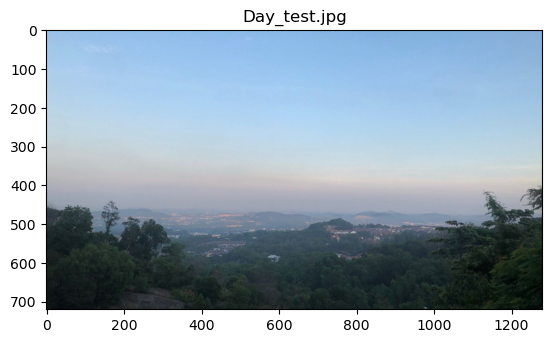

Test results (Day_test.jpg):  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Image Day_test.jpg is classified as Day


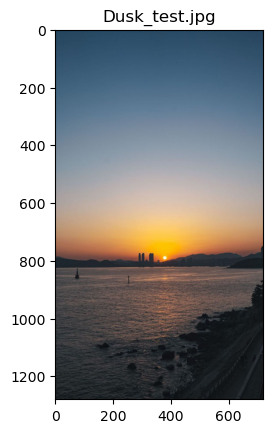

Test results (Dusk_test.jpg):  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Image Dusk_test.jpg is classified as Dusk


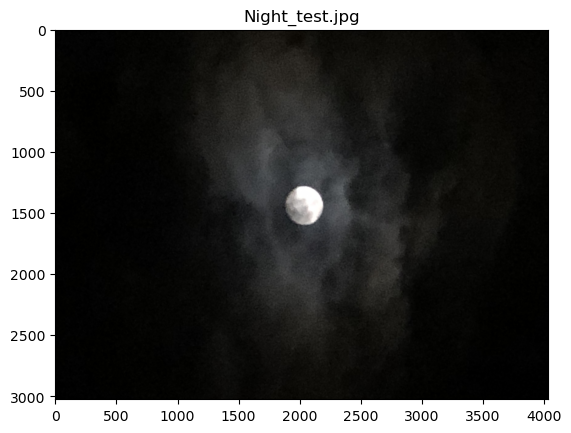

Test results (Night_test.jpg):  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Image Night_test.jpg is classified as Night


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)]

In [57]:
IMG_PATH = ["Day_test.jpg", "Dusk_test.jpg", "Night_test.jpg"]

# If not training from beginning, need to set the corresponding index_best_model and enalble_autoencoder_ls
# BEST_CNNA_PATH = "Models01/CNNA_0_0.01.pt"
# index_best_model = [4, 15, 28, 33, 34, 38, 46, 58, 59, 63]
# enable_autoencoder_ls = [False, False, False, False, False, True, False, False, False, False]

batch_label = []
labels = ['Day', 'Dusk', 'Night']

# Load the best CNN Autoencoder model
device = torch.device("cpu")
CNNA_model = CNNAutoencoder().to(device)
CNNA_model.load_state_dict(torch.load(BEST_CNNA_PATH, map_location=torch.device(device)))
CNNA_model.eval()
for param in CNNA_model.parameters():
    param.requires_grad = False

for j, img_path in enumerate(IMG_PATH):
    new_img = Image.open(img_path)
    plt.title(img_path)
    plt.imshow(new_img)
    plt.show()
    new_img          = np.array(re(img_path, new_size), dtype = np.float32)  # Open and reshape the image to new size
    
    if convert_RGB2HSV:
        new_img[:,:,0], new_img[:,:,2] =  new_img[:,:,2], new_img[:,:,0]     # Convert RGB to BGR 
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2HSV )                  # Convert BGR to HSV and normalize it
    new_img = torch.from_numpy(new_img).permute(2,0,1)  / 255                # Convert numpy array to pytorch tensor

    # Apply 7x7 gaussian low pass filter
    if applied_Gaussian:
        kernel_size, sigma2 = (7,7) , 4
        conv_layer = torch.nn.Conv2d(1, 1, kernel_size,padding="same")
        conv_layer.weight = torch.nn.Parameter(torch.from_numpy(gaussian_filter(kernel_size, sigma2))[None,None,:] )
        conv_layer.bias.data.fill_(0)

        with torch.no_grad():
            for k in range(3): # For each color channel
                new_img[k] = conv_layer((new_img[k])[None,None,:])

    new_img = new_img[None,:]
    
    # Load top 10 best model and do prediction on the image
    labels_temp = []
    for count, i in enumerate(index_best_model):
        
        load_model = NeuralNet(enable_autoencoder = enable_autoencoder_ls[count]).to(device)
        load_model.load_state_dict(torch.load(f"Models{convert_RGB2HSV}{applied_Gaussian}/NeuralNet_{i}.pt", map_location=torch.device(device)))
        load_model.eval()

        new_img = new_img.to(device)
        with torch.no_grad():
            outputs = load_model(new_img).cpu()
            label = torch.argmax(outputs, axis = 1).numpy()[0]
            labels_temp.append(label)
        load_model = load_model.to("cpu")
        new_img    = new_img.to("cpu")
    
    print(f"Test results ({img_path}): ", labels_temp)
    labels_temp = np.array(labels_temp)
    
    if (labels_temp == 0).sum() > (labels_temp == 1).sum() and (labels_temp == 0).sum() > (labels_temp == 2).sum():
        print("Image",img_path,"is classified as",labels[0])
        
    elif (labels_temp == 1).sum() > (labels_temp == 0).sum() and (labels_temp == 1).sum() > (labels_temp == 2).sum():
        print("Image",img_path,"is classified as",labels[1])
    else:
        print("Image",img_path,"is classified as",labels[2])
    batch_label.append(labels_temp)
    
CNNA_model = CNNA_model.to("cpu")
batch_label 
